In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

import time
import cv2


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
tf.random.set_seed(42)
np.random.seed(42)
batch_size = 32
codings_size = 100 ###################################################

class ResidualBlock(keras.layers.Layer):
    def __init__(self, strides=1):
        super().__init__()
        self.hidden = [tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", kernel_initializer="he_normal"),
                       tf.keras.layers.BatchNormalization(),
                       tf.keras.layers.PReLU(),
                       tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="SAME", kernel_initializer="he_normal"),
                       tf.keras.layers.BatchNormalization()
                       ]

    def call(self, inputs):
        Z = inputs
        Z1 = inputs
        for layer in self.hidden:
            Z = layer(Z)
            
        return Z+ Z1


In [3]:


class GENERATOR(keras.models.Model):
    def __init__(self):
        super().__init__()
        
        self.block1 = ResidualBlock()
        self.block2 = ResidualBlock()
        self.block3 = ResidualBlock()
        self.block4 = ResidualBlock()
        self.block5 = ResidualBlock()
        
        self.back1 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, kernel_initializer="he_normal", padding="SAME"), 
            tf.keras.layers.BatchNormalization()
        ])
        self.back4 = tf.keras.layers.Conv2D(filters=3, kernel_size=9, strides=1, kernel_initializer="he_normal", padding="SAME")
        
        global front1
        
        input_1 = tf.keras.layers.Input(shape=[56,56,3])
        front1=tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, kernel_initializer="he_normal", padding="SAME")(input_1)
        front1_2=tf.keras.layers.LeakyReLU(alpha=0.3)(front1)
        R_1=self.block1(front1_2)
        R_2=self.block2(R_1)
        R_3=self.block3(R_2)
        R_4=self.block4(R_3)
        R_5=self.block5(R_4)
        B_1=self.back1(R_5)
        self.F1 = keras.models.Model(inputs=[input_1], outputs=[B_1])
        
        input_2 = tf.keras.layers.Input(shape=[56,56,64])
        B_2=tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, kernel_initializer="he_normal", padding="SAME")(input_2)
        self.F2 = keras.models.Model(inputs=[input_2], outputs=[B_2])
        
        
        
        input_3 = tf.keras.layers.Input(shape=[112,112,64])
        B_23=tf.keras.layers.PReLU()(input_3)
        B_31=tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, kernel_initializer="he_normal", padding="SAME")(B_23)
        self.backz = tf.keras.models.Model(inputs=[input_3], outputs=[B_31])
        
        
        input_4 = tf.keras.layers.Input(shape=[224,224,64])
        B_33=tf.keras.layers.PReLU()(input_4)
        LO1=self.back4(B_33)
        self.backz2 = tf.keras.models.Model(inputs=[input_4], outputs=[LO1])
     

    def call(self, inputs):
        print(np.array(inputs).shape)
        A1=self.F1(inputs)
        A2=A1+front1
        A3=self.F2(A2)
        A4=tf.nn.depth_to_space(A3,block_size=2)
        A5=self.backz(A4)
        A6=tf.nn.depth_to_space(A5,block_size=2)
        A7=self.backz2(A6)
        return A7

In [4]:
discriminator = keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, kernel_initializer="he_normal", input_shape=[224,224,3]),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    
    tf.keras.layers.Dense(1024,kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Dense(1,activation='sigmoid', kernel_initializer="he_normal")
])

generator=GENERATOR()

SRGAN = keras.models.Sequential([generator, discriminator])

In [5]:
discriminator.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001F043AE2388>>

In [6]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [7]:
def print_status_bar(iteration, total, PSNR, SSIM, Global_loss, size=30):
    end = "" if iteration < total else "\n"
    print("\r{} - PSNR :{} , SSIM :{}, loss :{}".format(progress_bar(iteration, total), PSNR, SSIM, Global_loss), end=end)

In [8]:
import tensorflow_hub as hub
VGG=tf.keras.applications.VGG19(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)

VGG.summary()
type(VGG)
def content_loss (inputs, GENERATEING) :
    partial_VGG=VGG[0:11]
    compareSR_VGG=partial_VGG[GENERATEING]
    compareHR_VGG=partial_VGG[inputs]
    loss_var_SR_VGG=np.array(compareSR_HR[10])# shape 56, 56, 256
    loss_var_HR_VGG=np.array(compareSR_HR[10])# shape 56, 56, 256
    loss_pre=(loss_var_SR_VGG-loss_var_HR_VGG)**2
    loss_pre1=loss_pre.sum()
    H,W,CH=loss_var_SR_VGG.shape
    loss_content=loss_pre/(H*W)
    return loss_content


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
def train_discriminator (X_batch, Real_IMAGE, batch_size) :#############################수정
    global generated_image
    generated_images = generator(X_batch)
    X_fake_and_real = tf.concat([generated_images, Real_IMAGE], axis=0)
    y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
    #print(generated_images.shape)
    #print(Real_IMAGE.shape)
    #print(X_fake_and_real.shape)
    print(y1.dtype)
    discriminator.trainable = True
    with tf.GradientTape() as tape:
        y_pred = discriminator(X_fake_and_real, y1)
        global ad_loss
        ad_loss =- tf.math.log(y_pred)
    gradients = tape.gradient(loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    for variable in model.variables:
        if variable.constraint is not None:
            variable.assign(variable.constraint(variable))

In [10]:
def train_generator (X_batch, batch_size) :###################################수정
    y2 = tf.constant([[1.]] * batch_size)
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        y_pred=gan(X_batch, y2)
        global cont_loss
        cont_loss=content_loss(X_batch,generated_images)
    gradients = tape.gradient(loss, gan.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gan.trainable_variables))
    for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
    


In [11]:
def train_gan(dataset,Real_IMAGE, batch_size, n_epochs=1):
    generator, discriminator = SRGAN.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))# not shown in the book
        for step in range(1, n_steps + 1):
            X_batch= dataset##변화 가능
            train_discriminator(X_batch, Real_IMAGE, batch_size)
            train_generator(X_batch, batch_size)
            GLOBAL_loss=cont_loss+ad_loss*10**(-3)
            SSIM=tf.image.ssim(X_batch, generated_images)
            PSNR=tf.image.psnr(X_batch, generated_images)
        print_status_bar(step * batch_size, len(y_train),  PSNR, SSIM, GLOBAL_loss)
    print_status_bar(len(y_train), len(y_train),  PSNR, SSIM, GLOBAL_loss)



numpy.ndarray

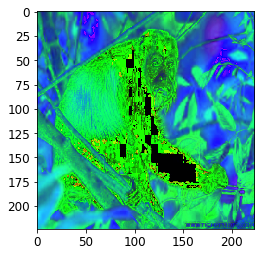

In [12]:
path ='C:/Users/user/ANACONDA TESTFILE/datasets/a/n0.jpg'

src = cv2.imread(path) 
RI_img=cv2.resize(src,(224,224), fx = 10, fy = 10)
image = cv2.cvtColor(RI_img, cv2.COLOR_BGR2HSV ) 

plt.imshow(image)#비교그림
type(src)

In [13]:
#RI_img=tf.expand_dims(RI_img,0)
type(RI_img[0,0,0])
print(RI_img.shape)
RI_img=RI_img/255
print(RI_img.shape)

(224, 224, 3)
(224, 224, 3)


In [14]:
R=[]
for i in range(0,10) :
    a='C:/Users/user/ANACONDA TESTFILE/datasets/a/n{}.jpg'.format(i)
    img = cv2.imread(a,1)
    bicubic_img = cv2.resize(img,(224,224), fx = 10, fy = 10, interpolation = cv2.INTER_CUBIC)
    bicubic_img=bicubic_img/255
    R.append(bicubic_img)
type(R)

list

In [15]:
print(np.array(R).shape)
R=np.array(R).astype('float32')

(10, 224, 224, 3)


In [16]:
D=[]
for i in range(0,10) :
    a='C:/Users/user/ANACONDA TESTFILE/datasets/a/n{}.jpg'.format(i)
    img = cv2.imread(a,1)
    bicubic_img = cv2.resize(img,(56,56), fx = 10, fy = 10, interpolation = cv2.INTER_CUBIC)
    bicubic_img=bicubic_img/255
    D.append(bicubic_img)

In [17]:
D=np.array(D).astype('float32')

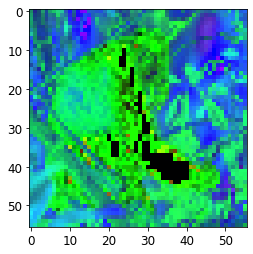

In [18]:
path ='C:/Users/user/ANACONDA TESTFILE/datasets/a/n0.jpg'

src = cv2.imread(path) 
TEST=cv2.resize(src,(56,56), fx = 10, fy = 10)
TEST = cv2.cvtColor(TEST, cv2.COLOR_BGR2HSV ) 

plt.imshow(TEST)#비교그림


In [19]:
len(D)

10

In [20]:
np.array(D).shape
type(D)

numpy.ndarray

In [21]:
n_epochs = 1
batch_size = 10
n_steps = len(D) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)

In [22]:
train_gan(D,R,10,1)

Epoch 1/1
(10, 56, 56, 3)
<dtype: 'float32'>


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()